In [1]:
import h5py, json
import time, copy, sys, os
import scipy.stats as ss
import numpy as np
import scipy
from scipy.stats import gaussian_kde
from scipy.special import logsumexp
from scipy.signal import savgol_filter

%matplotlib inline
import seaborn 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from importlib import reload

In [2]:
import sys
path = "../"
sys.path.append(path)

import functions, models, post_process, conversions
import read_pe_samples
from conversions import *

In [3]:
params = {'font.family': 'DejaVu Serif',
          'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'xtick.direction':'in',
          'ytick.direction':'in',
          'ytick.labelsize':'large','font.size':15}
plt.rcParams.update(params)
inches_to_cm = 2.54
figsize = (40/inches_to_cm, 13/inches_to_cm)
dpi = 300

colours = {}
colours['mchq'] = colours['m1q'] = '#1f77b4'
colours['m1qPL'] = '#ff7f0e'
colours['extended'] = 'steelblue'

In [4]:
results = {}
results['mchq'] = functions.read_results('../results/o1o2o3_model_I_ifar_1peryear_ng10.hdf5')
results['extended'] = functions.read_results('../results/o1o2o3_model_I_ifar_2peryear_ng10_with_asymmetric_binaries.hdf5')

results['m1q'] = functions.read_results('../results/o1o2o3_model_II_ifar_1peryear_ng10.hdf5')
results['m1qPL'] = functions.read_results('../results/o1o2o3_model_III_ifar_1peryear_ng10.hdf5')

In [5]:
for key in results.keys():
    res = results[key]
    nobs = res['args_sampler']['nobs']
    margl = res['posteriors']['margl']
    print(key, nobs, len(margl), np.round(logsumexp(margl) - np.log(len(margl)), 1), np.round(np.max(res['posteriors']['log_lkl']), 1))

mchq 69 2000 -198.1 -190.6
extended 72 2000 -207.1 -198.5
m1q 69 2500 -199.3 -191.3
m1qPL 69 2500 -202.2 -196.3


In [6]:
directory = '../plots/whats_in_a_parameter?'
print (directory)
if not os.path.exists(directory):
    os.makedirs(directory)

../plots/whats_in_a_parameter?


In [7]:
gwts = {}
locs_m1, stds_m1 = {}, {}
locs_mch, stds_mch = {}, {}
ngauss = results['m1q']['args_sampler']['ngauss']

gwts['mchq'] = results['mchq']['posteriors']['gwts']
locs_mch['mchq'] = results['mchq']['posteriors']['locs_mch']
stds_mch['mchq'] = results['mchq']['posteriors']['stds_mch']

gwts['m1q'] = results['m1q']['posteriors']['gwts']
locs_m1['m1q'] = results['m1q']['posteriors']['locs_m1']
stds_m1['m1q'] = results['m1q']['posteriors']['stds_m1']

gwts['m1qPL'] = results['m1qPL']['posteriors']['gwts']
locs_m1['m1qPL'] = results['m1qPL']['posteriors']['locs_m1']
stds_m1['m1qPL'] = results['m1qPL']['posteriors']['stds_m1']

breaks_m1 = [5, 14, 25, 47, 90]
breaks_mch = [4., 10, 18., 37., 65.]

### Plot the Mass Spectrum

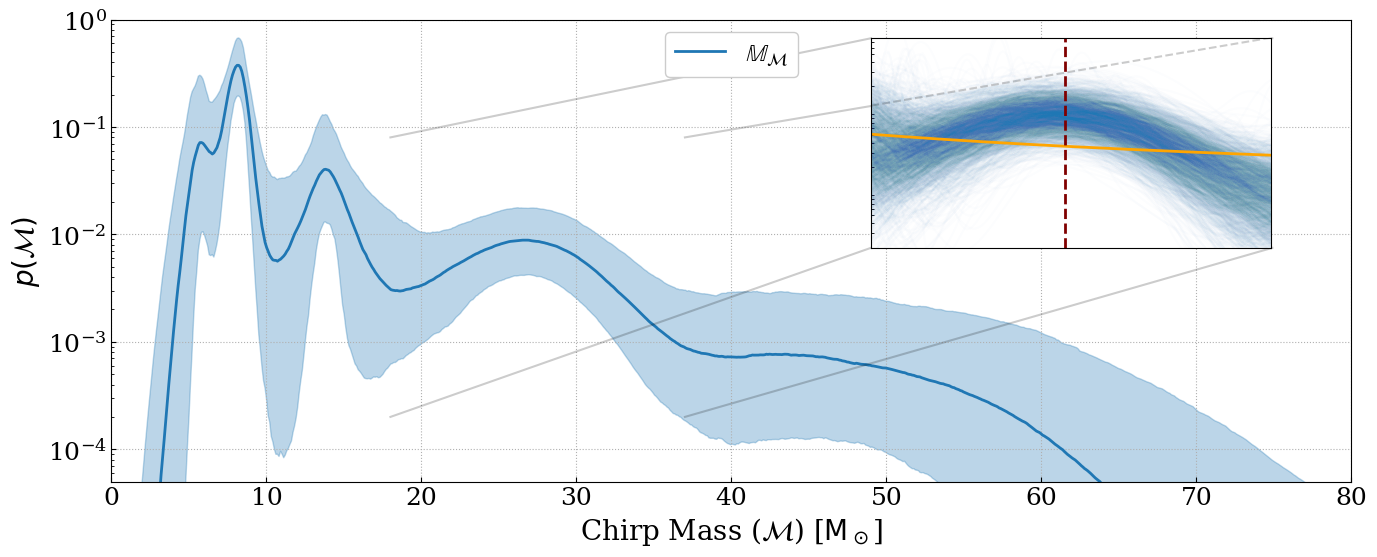

In [8]:
key = 'mchq'
res = results[key]
mch_ax = res['args_ppd']['mch_ax']
fig, ax1 = plt.subplots(figsize = (16.0, 6.0))
p5, p25, p50, p75, p95 = {}, {}, {}, {}, {}
CI = post_process.get_DiffRate_intervals(res['ppd']['post_pdf_mch'], 1, [5., 25., 50., 75., 95.])
p5[key], p25[key], p50[key], p75[key], p95[key] = CI
plt.plot(mch_ax, p50[key], linewidth = 2., label = '$\mathbb{M}_{\mathcal{M}}$', color = colours[key])
plt.fill_between(mch_ax, p5[key], p95[key], alpha = 0.3, color = colours[key])

plt.xlabel('Chirp Mass ($\mathcal{M}$) [$\mathrm{M}_\odot$]', fontsize=20)
plt.ylabel('$p(\mathcal{M})$',fontsize=20)
plt.xlim(0, 80.)
plt.ylim(.5e-4, 1.0)
plt.yscale('log')
plt.grid(ls=':')
plt.legend(loc = 'upper center', framealpha = 1.0)

left, bottom, width, height = [0.6, 0.5, 0.25, 0.35]
plt.plot([breaks_mch[2], 0.6 * mch_ax[-1] + 1], [0.0002, 0.0075], color='k', alpha=0.2)
plt.plot([breaks_mch[3], 0.95 * mch_ax[-1] - 1.1], [0.0002, 0.0075], color='k', alpha=0.2)
plt.plot([breaks_mch[2], 0.6 * mch_ax[-1] + 1], [0.08, 0.67], color='k', alpha=0.2)
plt.plot([breaks_mch[3], 0.95 * mch_ax[-1] - 1.1], [0.08, 0.67], color='k', alpha=0.2)


ax2 = fig.add_axes([left, bottom, width, height])
idxsel = np.where((mch_ax > breaks_mch[2]) & (mch_ax < breaks_mch[3]))
for jj, ppd in enumerate(res['ppd']['post_pdf_mch']):
    ax2.plot(mch_ax[idxsel], ppd[idxsel], color = colours[key], alpha=0.01)
ax2.plot(mch_ax[idxsel], 0.07 * models.powerlaw_pdf(mch_ax[idxsel], breaks_mch[2], breaks_mch[3], .83), color='orange', linewidth = 2.)
#best fit alpha
ax2.axvline(x=27.2, color='maroon', linestyle='--', linewidth = 2.)
ax2.set_yscale('log')
ax2.set_xlim(breaks_mch[2], breaks_mch[3])
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([]) 
ax2.set_ylim(0.0002, 0.08)#matches the inset boundary

plt.plot([breaks_mch[2], breaks_mch[3]], [0.0115, 0.08], color='k', alpha = 0.2, linestyle='--')

plt.savefig('../plots/whats_in_a_parameter?/confidence_mch.jpg', dpi = dpi, bbox_inches = 'tight')

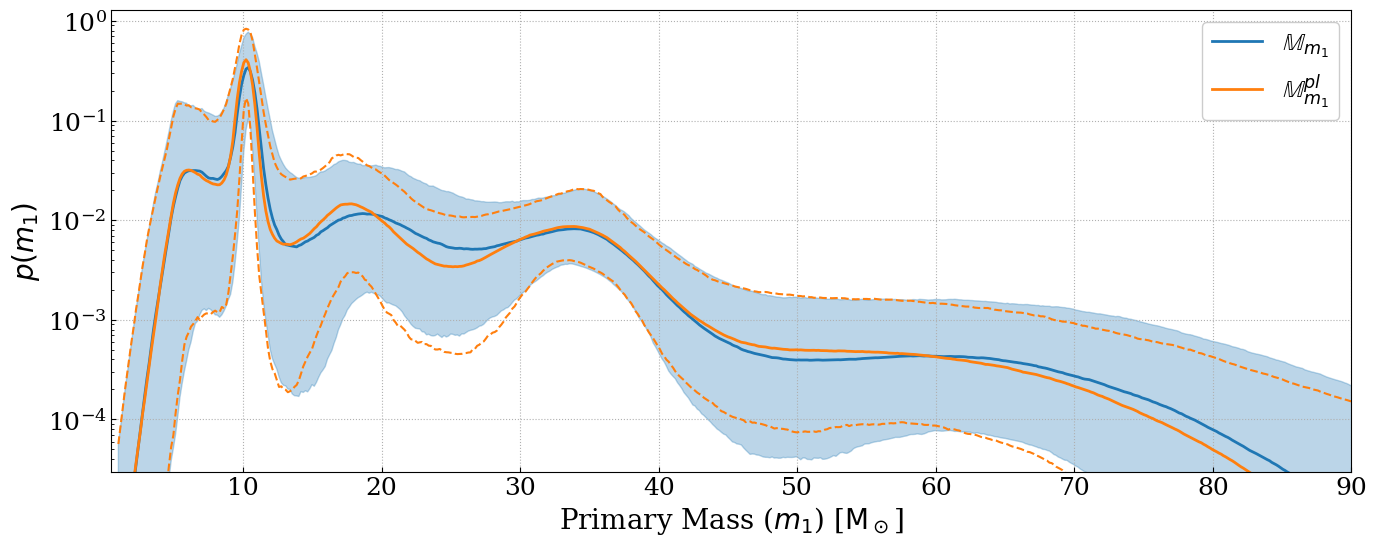

In [9]:
key = 'm1q'
res = results[key]
mass_ax = res['args_ppd']['mass_ax']
fig = plt.figure(figsize = (16.0, 6.0))
p5, p25, p50, p75, p95 = {}, {}, {}, {}, {}
CI = post_process.get_DiffRate_intervals(res['ppd']['post_pdf_mass1'], 1, [5., 25., 50., 75., 95.])
p5[key], p25[key], p50[key], p75[key], p95[key] = CI
plt.plot(mass_ax, p50[key], linewidth = 2., label = '$\mathbb{M}_{m_1}$', color = colours[key])
plt.fill_between(mass_ax, p5[key], p95[key], alpha = 0.3, color = colours[key])

key = 'm1qPL'
res = results[key]
p5, p25, p50, p75, p95 = {}, {}, {}, {}, {}
CI = post_process.get_DiffRate_intervals(res['ppd']['post_pdf_mass1'], 1, [5., 25., 50., 75., 95.])
p5[key], p25[key], p50[key], p75[key], p95[key] = CI
plt.plot(mass_ax, p50[key], linewidth = 2., label = '$\mathbb{M}^{pl}_{m_1}$', color = colours[key])
plt.plot(mass_ax, p5[key], color = colours[key], linestyle = '--')
plt.plot(mass_ax, p95[key], color = colours[key], linestyle = '--')

plt.xlabel('Primary Mass ($m_1$) [$\mathrm{M}_\odot$]', fontsize=20)
plt.ylabel('$p(m_1)$', fontsize=20)
plt.xlim(0.5, 90.)
plt.ylim(0.3e-4, 1.3)
plt.yscale('log')
plt.grid(ls=':')
plt.legend(loc = 'best', framealpha = 1.0)
plt.savefig('../plots/whats_in_a_parameter?/confidence_m1.jpg', dpi = dpi, bbox_inches = 'tight')

In [10]:
res = results['m1q']
ngauss = res['args_sampler']['ngauss']
gwts = res['posteriors']['gwts']
rate = res['posteriors']['rate']

q_norm = res['posteriors']['q_norm']
m1q_corr = res['posteriors']['m1q_corr']

m1ax = np.linspace(4., 84., 161)
qax = np.linspace(0.05, 1., 96)
xy, yx = np.meshgrid(m1ax, qax)
xy_flat, yx_flat = xy.flatten(), yx.flatten()
all_rate_m1q = []
for ii in range(len(rate)):
    post_pdf_m1q = 0
    for jj in range(ngauss):
        mean = [res['posteriors']['locs_m1'][ii][jj], res['posteriors']['locs_q'][ii][jj]]
        cov = np.diag([res['posteriors']['stds_m1'][ii][jj], res['posteriors']['stds_q'][ii][jj]]) ** 2
        cov[0][1] = cov[1][0] = m1q_corr[ii][jj] * res['posteriors']['stds_m1'][ii][jj] * res['posteriors']['stds_q'][ii][jj]
        x = np.transpose([xy_flat, yx_flat])
        rvs = scipy.stats.multivariate_normal(mean = mean, cov = cov)
        logpdf = rvs.logpdf(x)
        logpdf += np.log(gwts[ii][jj])
        post_pdf_m1q += np.exp(logpdf) / q_norm[ii][jj]
    post_pdf_m1q = post_pdf_m1q.reshape(xy.shape)
    if ii % 500 == 0:
        print (ii)
    rate_m1q = rate[ii] * post_pdf_m1q
    all_rate_m1q.append(rate_m1q)
    
mean_rate_m1q = np.mean(all_rate_m1q, axis = 0)
mean_rate_m1q = np.transpose(mean_rate_m1q)

p50_m1q, p90_m1q = [], []
for ii, _ in enumerate(m1ax):
    pdf = mean_rate_m1q[ii]
    cdf = np.cumsum(pdf)
    cdf /= cdf[-1]
    p50_m1q.append(qax[np.where(cdf > 0.5)[0][0]])
    p90_m1q.append(qax[np.where(cdf > 0.1)[0][0]])

0
500
1000
1500
2000


(0.15995454545454516, 1.006)

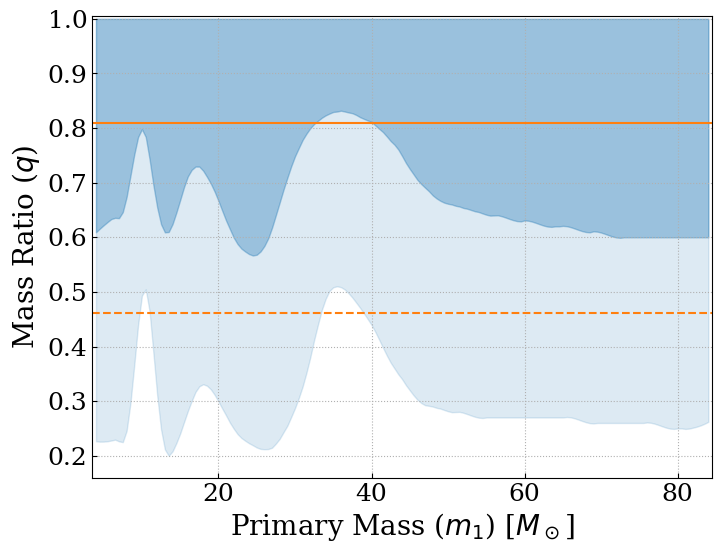

In [11]:
key = 'm1q'
result = results['m1qPL']
rate = result['posteriors']['rate']
ppd_q = result['ppd']['ppd_q']
idx = [np.random.choice(range(len(ppd_q[ii])), size = int(rate[ii] * 6), replace=False) for ii in range(len(rate))]
ppd_q_ratewise = np.concatenate([ppd_q[ii][idx[ii]] for ii in range(len(rate))])

fig = plt.figure(figsize = (8.0, 6.0))
plt.fill_between(m1ax, np.ones_like(m1ax), savgol_filter(p90_m1q, 9, 2), alpha = 0.15, color = colours[key])
plt.fill_between(m1ax, np.ones_like(m1ax), savgol_filter(p50_m1q, 9, 2), alpha = 0.35, color = colours[key])
# 10/50 percentile for model III that uses one power-law to model populations mass ratio distribution
plt.axhline(y=np.percentile(ppd_q_ratewise, 50), color = colours['m1qPL'])
plt.axhline(y=np.percentile(ppd_q_ratewise, 9), color = colours['m1qPL'], linestyle = '--')
plt.grid(ls=':')
plt.xlabel('Primary Mass ($m_1$) [$M_\odot$]', fontsize=20)
plt.ylabel('Mass Ratio ($q$)', fontsize=20)
plt.xlim(m1ax[0]-0.5, m1ax[-1]+0.5)
plt.ylim(None, 1.0 + 0.006)

### Plots related to Extended analysis


In [12]:
res = results['extended']
ngauss = res['args_sampler']['ngauss']
locs_q = res['posteriors']['locs_q']
stds_q = res['posteriors']['stds_q']
locs_sz = res['posteriors']['locs_sz']
stds_sz = res['posteriors']['stds_sz']
gwts = res['posteriors']['gwts']
rate = res['posteriors']['rate']
ppd_q = res['ppd']['ppd_q']

q_norm = res['posteriors']['q_norm']
sz_norm = res['posteriors']['sz_norm']
mchq_corr = res['posteriors']['mchq_corr']

mchax = np.linspace(4., 65., 113)
qax = np.linspace(0.05, 1., 96)
xy, yx = np.meshgrid(mchax, qax)
xy_flat, yx_flat = xy.flatten(), yx.flatten()
all_rate_mchq = []
for ii in range(len(rate)):
    post_pdf_mchq = 0
    for jj in range(ngauss):
        mean = [res['posteriors']['locs_mch'][ii][jj], locs_q[ii][jj]]
        cov = np.diag([res['posteriors']['stds_mch'][ii][jj], stds_q[ii][jj]]) ** 2
        cov[0][1] = cov[1][0] = mchq_corr[ii][jj] * res['posteriors']['stds_mch'][ii][jj] * stds_q[ii][jj]
        x = np.transpose([xy_flat, yx_flat])
        rvs = scipy.stats.multivariate_normal(mean = mean, cov = cov)
        logpdf = rvs.logpdf(x)
        logpdf += np.log(gwts[ii][jj])
        post_pdf_mchq += np.exp(logpdf) / q_norm[ii][jj]
    post_pdf_mchq = post_pdf_mchq.reshape(xy.shape)
    if ii % 500 == 0:
        print (ii)
    rate_mchq = rate[ii] * post_pdf_mchq
    all_rate_mchq.append(rate_mchq)
    
mean_rate_mchq = np.mean(all_rate_mchq, axis = 0)
mean_rate_mchq = np.transpose(mean_rate_mchq)

p50_mchq, p90_mchq = [], []
for ii, _ in enumerate(mchax):
    pdf = mean_rate_mchq[ii]
    cdf = np.cumsum(pdf)
    cdf /= cdf[-1]
    p50_mchq.append(qax[np.where(cdf > 0.5)[0][0]])
    p90_mchq.append(qax[np.where(cdf > 0.1)[0][0]])

0
500
1000
1500


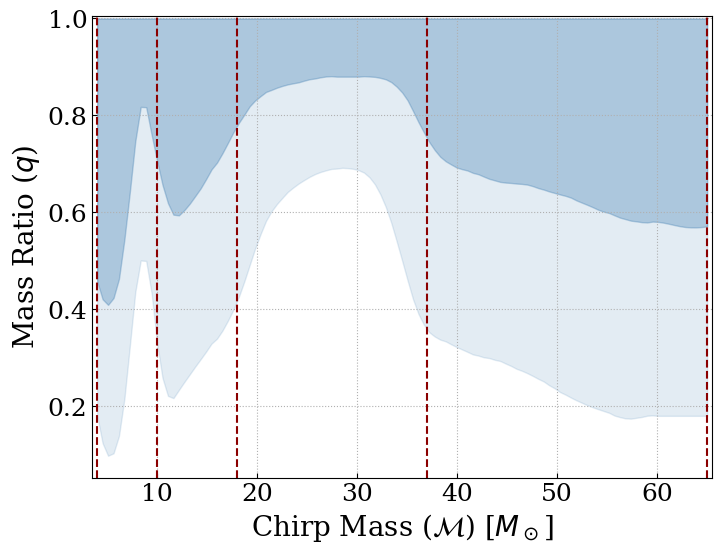

In [13]:
key = 'extended'
p90_prior = np.random.normal()
fig = plt.figure(figsize = (8.0, 6.0))
plt.fill_between(mchax, np.ones_like(mchax), savgol_filter(p90_mchq, 9, 2), alpha = 0.15, color = colours[key])
plt.fill_between(mchax, np.ones_like(mchax), savgol_filter(p50_mchq, 9, 2), alpha = 0.35, color = colours[key])
for kk in range(5):
    plt.axvline(x=breaks_mch[kk], color = 'darkred', linestyle='--')
#plt.axvline(x=max(m95l), color='r')
#plt.axvline(x=min(m5r), color='r')
plt.grid(ls=':')
plt.xlabel('Chirp Mass ($\mathcal{M}$) [$M_\odot$]', fontsize=20)
plt.ylabel('Mass Ratio ($q$)', fontsize=20)
plt.xlim(mchax[0]-0.5, mchax[-1]+0.5)
plt.ylim(None, 1.0 + 0.006)
plt.savefig('../plots/whats_in_a_parameter?/q_vs_mch.jpg', dpi = dpi, bbox_inches = 'tight')